## Importing Libraries

In [ ]:
# For data preprocessing
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# To build visualizations
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Project/store-sales-time-series-forecasting

/content/drive/My Drive/Colab Notebooks/Project/store-sales-time-series-forecasting


In [ ]:
train = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
transactions = pd.read_csv("transactions.csv")
holidays_events = pd.read_csv("holidays_events.csv")
test = pd.read_csv("test.csv")

In [ ]:
train.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [ ]:
#Merge train data for analysis and modeling
train = train.merge(stores, how="left", on='store_nbr')   
train = train.merge(oil, how="left", on='date')      
train = train.merge(transactions, how="left", on=['date','store_nbr'])  
train = train.merge(holidays_events,on='date',how='left')
train = train.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

#Merge test data for analysis and modeling
test = test.merge(stores, how="left", on='store_nbr')   
test = test.merge(oil, how="left", on='date')      
test = test.merge(holidays_events,on='date',how='left')
test = test.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

In [ ]:
train.tail()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,locale,locale_name,description,transferred
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054347,3000887,2017-08-15,9,SEAFOOD,16.000,0,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [ ]:
train.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
dcoilwtico       955152
transactions     249117
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

In [ ]:
test.isnull().sum()

id                  0
date                0
store_nbr           0
family              0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
dcoilwtico       7128
holiday_type    26730
locale          26730
locale_name     26730
description     26730
transferred     26730
dtype: int64

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28512 entries, 0 to 28511
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            28512 non-null  int64  
 1   date          28512 non-null  object 
 2   store_nbr     28512 non-null  int64  
 3   family        28512 non-null  object 
 4   onpromotion   28512 non-null  int64  
 5   city          28512 non-null  object 
 6   state         28512 non-null  object 
 7   store_type    28512 non-null  object 
 8   cluster       28512 non-null  int64  
 9   dcoilwtico    21384 non-null  float64
 10  holiday_type  1782 non-null   object 
 11  locale        1782 non-null   object 
 12  locale_name   1782 non-null   object 
 13  description   1782 non-null   object 
 14  transferred   1782 non-null   object 
dtypes: float64(1), int64(4), object(10)
memory usage: 3.5+ MB


In [ ]:
dup = train[train.duplicated(subset=train.columns.tolist(), keep=False)]
print(f"Duplicate records in train: {dup.shape[0]}")

dup = test[test.duplicated(subset=test.columns.tolist(), keep=False)]
print(f"Duplicate records in test: {dup.shape[0]}")

Duplicate records in train: 0
Duplicate records in test: 0


In [ ]:
common_df = pd.merge(
    train,
    test,
    how='inner',
    on=test.columns.tolist()
)

print(f"Leakage records: {common_df.shape[0]}")
common_df.head()

Leakage records: 0


,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,locale,locale_name,description,transferred


## Missing Values Handling

In [ ]:
train.dropna(subset=['store_nbr'], axis=0, inplace=True)

### 1.1 Oil Price

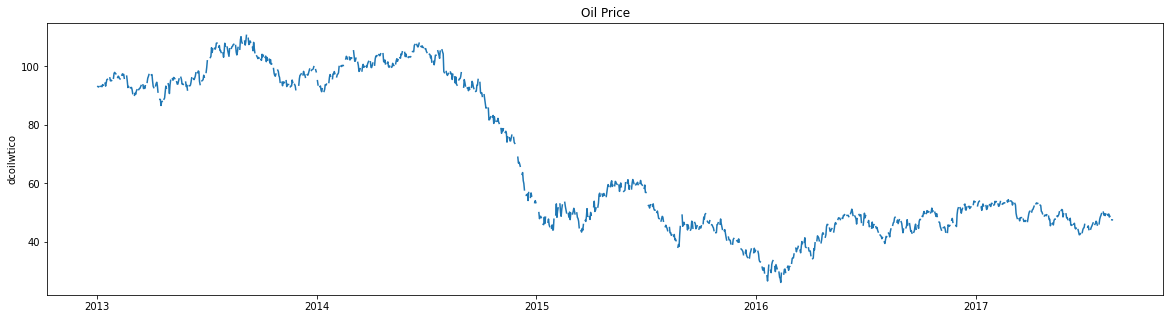

In [ ]:
oil_mis = train.set_index("date").dcoilwtico.resample("D").mean().reset_index()
plt.rcParams['figure.figsize'] = (20, 5)
plt.title('Oil Price')
plt.ylabel('dcoilwtico')
plt.plot(oil_mis['date'],oil_mis['dcoilwtico']);

In [ ]:
train['dcoilwtico'] = train['dcoilwtico'].fillna(method='bfill')
test['dcoilwtico'] = test['dcoilwtico'].fillna(method='bfill')

0

### 1.2 Transactions

In [ ]:
train.transactions = train.transactions.replace(np.nan,0)

### 1.3 Holiday Events

In [ ]:
#Missing value handling for holiday and event columns in train data
train[['locale','locale_name', 'description']] = train[['locale','locale_name', 'description']].replace(np.nan,'')
train['holiday_type'] = train['holiday_type'].replace(np.nan,'Work Day')
train['transferred'] = train['transferred'].replace(np.nan,False)

#Missing value handling for holiday and event columns in test
test[['locale','locale_name', 'description']] = test[['locale','locale_name', 'description']].replace(np.nan,'')
test['holiday_type'] = test['holiday_type'].replace(np.nan,'Work Day')
test['transferred'] = test['transferred'].replace(np.nan,False)

# Feature Engineering

## Extracting date information

In [ ]:
#Exctracting date information from train data
train['date'] = pd.to_datetime(train['date'])
train['Quarter'] = train['date'].apply(lambda x: pd.to_datetime(x).quarter)
train['Week'] = train['date'].apply(lambda x: pd.to_datetime(x).week)
train['DayofWeek'] = train['date'].apply(lambda x: pd.to_datetime(x).dayofweek)
train['isWeekend'] = np.where(train['DayofWeek'].isin([5,6]),1,0)
train['Month'] = train['date'].apply(lambda x: pd.to_datetime(x).month)
train['Year'] = train['date'].apply(lambda x: pd.to_datetime(x).year)
train['Day'] = train['date'].apply(lambda x: pd.to_datetime(x).day)
train['season'] = train['Month'].apply(lambda x: 0 if x in [2,3] else 1 if x in [4,5,6] else 2 if x in [7,8] else 3 if x in [9,10,11] else 4)

#Exctracting date information from test data
test['date'] = pd.to_datetime(train['date'])
test['Quarter'] = test['date'].apply(lambda x: pd.to_datetime(x).quarter)
test['Week'] = test['date'].apply(lambda x: pd.to_datetime(x).week)
test['DayofWeek'] = test['date'].apply(lambda x: pd.to_datetime(x).dayofweek)
test['isWeekend'] = np.where(test['DayofWeek'].isin([5,6]),1,0)
test['Month'] = test['date'].apply(lambda x: pd.to_datetime(x).month)
test['Year'] = test['date'].apply(lambda x: pd.to_datetime(x).year)
test['Day'] = test['date'].apply(lambda x: pd.to_datetime(x).day)
test['season'] = test['Month'].apply(lambda x: 0 if x in [2,3] else 1 if x in [4,5,6] else 2 if x in [7,8] else 3 if x in [9,10,11] else 4)

In [ ]:
#Created a new feature, the length of the day leading to thanksgiving and christmas on train data
train['Days_to_Thansksgiving'] = (pd.to_datetime(train["Year"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(train["date"], format="%Y-%m-%d")).dt.days.astype(int)
train['Days_to_Christmas'] = (pd.to_datetime(train["Year"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(train["date"], format="%Y-%m-%d")).dt.days.astype(int)

#Created a new feature, the length of the day leading to thanksgiving and christmas on test data
test['Days_to_Thansksgiving'] = (pd.to_datetime(test["Year"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(test["date"], format="%Y-%m-%d")).dt.days.astype(int)
test['Days_to_Christmas'] = (pd.to_datetime(test["Year"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(test["date"], format="%Y-%m-%d")).dt.days.astype(int)

In [ ]:
#Log value of sales to avoid negative predicted sales value
train['log_sales'] = np.log(train['sales']+1)

## Categorical data encoding

In [ ]:
#Encoding store type column to an ordinal feature based on sales
storetype_values = {'A':5, 'D':4, 'B':3, 'E':2, 'C':1}
train['store_type'] = train.store_type.map(storetype_values)
test['store_type'] = test.store_type.map(storetype_values)

#Encoding holiday type column to an ordinal feature based on sales
holidaytype_values = {'Additional':6, 'Transfer':5, 'Bridge':4, 'Event':3, 'Holiday':2, 'Work Day':1}
train['holiday_type'] = train.holiday_type.map(holidaytype_values)
test['holiday_type'] = test.holiday_type.map(holidaytype_values)

#Encoding locale column to an ordinal feature based on sales
locale_values = {'National':4, 'Regional':3, 'Local':2, '':1}
train['locale'] = train.locale.map(locale_values)
test['locale'] = test.locale.map(locale_values)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
feature = ['family','city','state','locale_name','transferred']
train[feature] = train[feature].apply(le.fit_transform)
test[feature] = test[feature].apply(le.fit_transform)

## Forecast Modelling (CatBoost)

In [ ]:
# To build ML models
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas.util.testing as tm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit
from xgboost import plot_importance, plot_tree
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV


sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10') # for graph stying

In [ ]:
model_features = ['store_nbr', 'family', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'dcoilwtico',
       'holiday_type', 'locale', 'locale_name', 'transferred',
       'isWeekend', 'Year', 'season',
       'Days_to_Thansksgiving', 'Days_to_Christmas', 'Month', 'Quarter',
       'Week', 'DayofWeek','Day']

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,Quarter,Week,DayofWeek,isWeekend,Month,Year,Day,season,Days_to_Thansksgiving,Days_to_Christmas
0,0,2013-01-01,1,0,0.0,0,18,12,4,13,...,1,1,1,0,1,2013,1,4,327,357
1,1,2013-01-01,1,1,0.0,0,18,12,4,13,...,1,1,1,0,1,2013,1,4,327,357
2,2,2013-01-01,1,2,0.0,0,18,12,4,13,...,1,1,1,0,1,2013,1,4,327,357
3,3,2013-01-01,1,3,0.0,0,18,12,4,13,...,1,1,1,0,1,2013,1,4,327,357
4,4,2013-01-01,1,4,0.0,0,18,12,4,13,...,1,1,1,0,1,2013,1,4,327,357


In [ ]:
train.date = pd.to_datetime(train.date)

#Create train and test data from a train data frame for modeling and model evaluation
split_date = "2017.07.15"
df_train_model = train.loc[train.date <= split_date].copy()
df_test_model = train.loc[train.date > split_date].copy()

df_test_model.set_index('date', inplace=True)
df_train_model.set_index('date', inplace=True)

In [ ]:
#Splitting the data for modelling
Y = df_train_model['log_sales']
X = df_train_model[model_features]
test_size = .3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state = 3)

In [ ]:
#RMSLE value function
def rmsle(h, y): 
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

In [ ]:
#Catboost model
cat_reg = CatBoostRegressor(num_boost_round=5000,learning_rate=0.123,reg_lambda=0.1724,bootstrap_type='Poisson',subsample=0.6654,max_depth=8,
          task_type='GPU',grow_policy='Lossguide',min_data_in_leaf=8, max_leaves=117,verbose=0,random_state=42)
cat_reg.fit(X_train, y_train)
prediction = cat_reg.predict(X_test)
#cv = ShuffleSplit(n_splits=4, test_size=0.3, random_state=0)
# print('cv model score = ',cross_val_score(xgb_reg, X, Y, cv=cv))
# Model score
print('RMSLE = ', rmsle(prediction,y_test))
print('Model score = ', cat_reg.score(X_test,y_test))

RMSLE =  0.22338798653199485
Model score =  0.9780535568111487


Text(0.5, 1.0, 'Feature Importance')

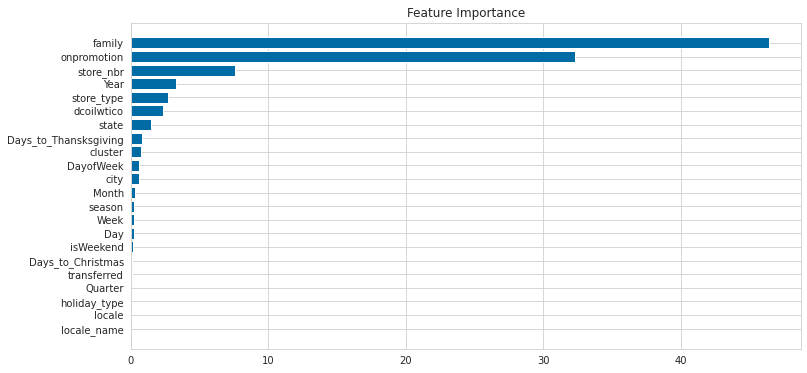

In [ ]:
#Feature impotance
feature_importance = cat_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

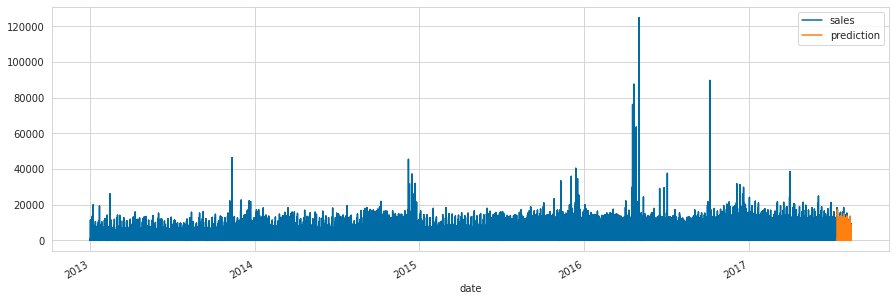

In [ ]:
#Real and prediction value trend
df_test_model['prediction'] = ((np.exp(cat_reg.predict(df_test_model[model_features])))-1)
df_all = pd.concat([df_test_model, df_train_model], sort=False)
_ = df_all[['sales','prediction']].plot(figsize=(15, 5))

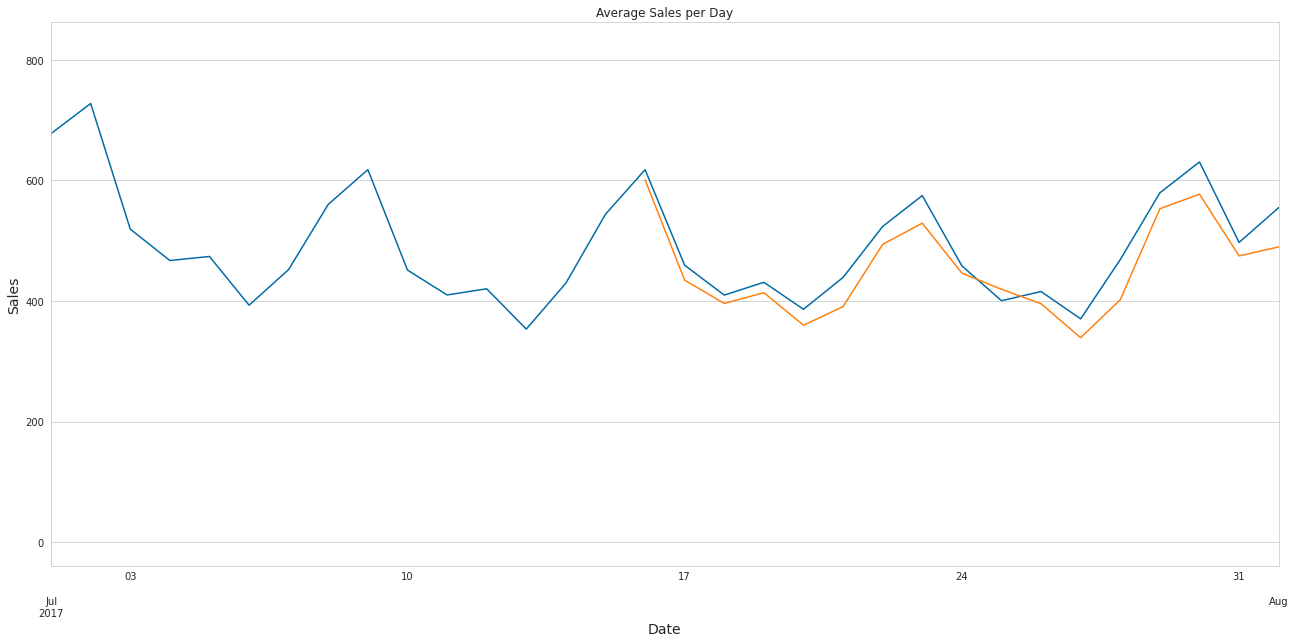

In [ ]:
#Evaluate real dan prediction data 
sales = df_all.sales.resample("D").mean()
prediction = df_all.prediction.resample("D").mean()

f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(22)

sales.plot(ax=ax)
prediction.plot(ax=ax)

#ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)
ax.set_title('Average Sales per Day')
ax.set_xbound(lower='2017.07.01', upper='2017.08.01')

plt.show()

In [ ]:
df_test_model[['sales','prediction']].head(10)

,sales,prediction
date,,
2017-07-16,2.000,1.815036
2017-07-16,0.000,-0.007305
2017-07-16,2.000,1.232851
2017-07-16,1079.000,1160.703735
2017-07-16,0.000,-0.070967
2017-07-16,121.055,184.568445
2017-07-16,9.000,4.664903
2017-07-16,231.000,248.535786
2017-07-16,325.000,333.393098


## Forecasting on test data

In [ ]:
#Making sales prediction on test data
test['prediction'] = ((np.exp(lgb_reg.predict(test[model_features])))-1)  
test['prediction'] = test['prediction'].astype(int)
test[test['prediction'] < 0] = 0

In [ ]:
test[['id','prediction']].head(20)

,id,prediction
0,3000888,4
1,3000889,0
2,3000890,6
3,3000891,2700
4,3000892,0
5,3000893,517
6,3000894,0
7,3000895,1068
8,3000896,743
9,3000897,232


# Conclusion

- Based on forecasting from the light gbm model that has been made, an rmsle value of 0.22 is obtained which indicates a very small error. this error value is smaller than the xgboost regression ang light gbm model

- In addition, the model score obtained is very high, 97.80% so that this model can properly explain the diversity of the data and can produce accurate predictions.